In [48]:
import polars as pl
import pandas as pd
import numpy as np
from enum import Enum
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Input,  TimeDistributed, concatenate
from keras import regularizers, optimizers
from keras.utils import plot_model
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping



#Data manipulation

#This test using this data collumns
columns_to_normalize = ["close", "ema5", "ema20" , "macd520"]

#reading the data that already shuffled and arranged
def read_data(train_file = 'train_data.csv', val_file = 'val_data.csv', test_file = 'test_data.csv'):
    train_data = pl.read_csv(train_file)
    val_data = pl.read_csv(val_file)
    test_data = pl.read_csv(test_file)
    return train_data, val_data, test_data

#get data of x and y and return x and y, slice y
def extract_y(data):
    y = data['NEXT_1_MIN']
    x = data.drop('NEXT_1_MIN')
    return x,y


#we should not use min max scale cause the max changing over the time.
#we need to deal with two kinds of things : 1. train data - we need to create a scaler and fit it to the train, and then create a normalized data , 2. test/validation data - we should get as input the scaler of the train, and do normalize by him
def min_max_scaler(data):
    scaler = preprocessing.MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

#This scaler do the scaling as gaussian scaler
def z_score_normalize(data):
    scaler = preprocessing.StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler
    

def normalized_x_y(x: pl.DataFrame, y: pl.DataFrame, columns_to_normalize: list):
    # Convert Polars DataFrame to NumPy array for normalization
    x_values = x.select(columns_to_normalize).to_numpy()
    y_values = y.to_numpy().reshape(-1, 1)
    # Normalize
    normalized_x_values, scaler_x = z_score_normalize(x_values)
    normalized_y_values, scaler_y = z_score_normalize(y_values)
    # Convert back to Polars DataFrame
    normalized_x = pl.DataFrame(normalized_x_values, schema=columns_to_normalize)
    normalized_y = pl.DataFrame(normalized_y_values, schema=['normalized_y'])

    return normalized_x, normalized_y, scaler_x, scaler_y

In [49]:
train_data, val_data, test_data = read_data()
x_train, y_train = extract_y(train_data)
x_val, y_val = extract_y(val_data)
x_test, y_test = extract_y(test_data)


In [50]:
# Split data to train val and test and normalize the data
x_train, y_train, x_train_scaler, y_train_scaler = normalized_x_y(x_train, y_train, columns_to_normalize)
x_val, y_val, x_val_scaler, y_val_scaler = normalized_x_y(x_val, y_val, columns_to_normalize)
x_test, y_test, x_test_scaler, y_test_scaler = normalized_x_y(x_test, y_test, columns_to_normalize)
print(x_test[:3])
print(y_test[:3])

shape: (3, 4)
┌───────────┬───────────┬───────────┬───────────┐
│ close     ┆ ema5      ┆ ema20     ┆ macd520   │
│ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.968311 ┆ -0.961899 ┆ -0.959462 ┆ -0.744139 │
│ -0.968109 ┆ -0.963969 ┆ -0.960285 ┆ -1.140859 │
│ -0.966712 ┆ -0.964883 ┆ -0.960897 ┆ -1.237162 │
└───────────┴───────────┴───────────┴───────────┘
shape: (3, 1)
┌──────────────┐
│ normalized_y │
│ ---          │
│ f64          │
╞══════════════╡
│ -0.968103    │
│ -0.966707    │
│ -0.965175    │
└──────────────┘


In [51]:
# all this block will preapre the data as the needed size for the lstm model
def prepare_lstm_data(x, y, history_points, day_size):
    x_sequences = create_sequences(x, history_points, day_size)
    y_sequences = create_target_sequences(y, history_points, day_size)
    return x_sequences, y_sequences

def create_sequences(data, history_points, day_size):
    sequences = []
    
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate sequences within the current day
        for i in range(day_start, day_end - history_points + 1):
            sequences.append(data[i:i + history_points])
    
    return np.array(sequences)

#creating y data
def create_target_sequences(data, history_points, day_size):
    target_sequences = []
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate target sequences within the current day
        for i in range(day_start+history_points-1, day_end ):
            target_sequences.append(data[i])  # Get the y of the last element in the sequence(the y of the 10 number)
    return np.array(target_sequences).reshape(-1, 1)  # Reshape to (batch_size, 1, 1)




In [52]:


#Generic function that allow to create model with multiplie optione (regulations,dropout, batch sizes)
def model_creator(lstm_layer1_size, 
                  lstm_layer2_size=None, 
                  regular_layer1_size=None, 
                  regular_layer2_size=None,
                  L1=0, L2=0, 
                  dropout=0, 
                  history_points=10, 
                  x_train=None, y_train=None,
                  x_val=None, y_val=None,
                  batch_size=512, 
                  learning_rate=0.0005, 
                  epochs=50):
    # Building the model
    model = Sequential()

    # Adding first LSTM layer with optional regularization and dropout
    if L1:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, len(columns_to_normalize)), 
                       kernel_regularizer=regularizers.l1(L1),return_sequences=(lstm_layer2_size is not None),activation="relu"))
    elif L2:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, len(columns_to_normalize)), 
                       kernel_regularizer=regularizers.l2(L2),return_sequences=(lstm_layer2_size is not None),activation="relu"))
    else:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, len(columns_to_normalize)),return_sequences=(lstm_layer2_size is not None),activation="relu")
 )
    
    if dropout:
        model.add(Dropout(dropout))

    # Adding second LSTM layer if reuired too
    if lstm_layer2_size:
        if L1:
            model.add(LSTM(lstm_layer2_size, kernel_regularizer=regularizers.l1(L1),return_sequences=False,activation="relu"))
        elif L2:
            model.add(LSTM(lstm_layer2_size, kernel_regularizer=regularizers.l2(L2), return_sequences=False,activation="relu"))
        else:
            model.add(LSTM(lstm_layer2_size, return_sequences=False))
        
        if dropout:
            model.add(Dropout(dropout))
    
    # Adding first regular Dense layer if reuired too
    if regular_layer1_size:
        if L1:
            model.add(Dense(regular_layer1_size, kernel_regularizer=regularizers.l1(L1), activation="relu"))
        elif L2:
            model.add(Dense(regular_layer1_size, kernel_regularizer=regularizers.l2(L2), activation="relu"))
        else:
            model.add(Dense(regular_layer1_size, activation="relu"))
        
        if dropout:
            model.add(Dropout(dropout))

    # Adding second regular Dense layer if reuired too
    if regular_layer2_size:
        if L1:
            model.add(Dense(regular_layer2_size, kernel_regularizer=regularizers.l1(L1), activation="relu"))
        elif L2:
            model.add(Dense(regular_layer2_size, kernel_regularizer=regularizers.l2(L2), activation="relu"))
        else:
            model.add(Dense(regular_layer2_size, activation="relu"))
        
        if dropout:
            model.add(Dropout(dropout))

    # Final output layer
    model.add(Dense(1, activation="linear"))

    #Our problem is Regression(we predict continuously val) and Accuracy suits for classification problems and for our one
    # Compile the model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss="mse", metrics=[MeanAbsoluteError(),MeanAbsolutePercentageError()])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Training the model with train data and already
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping])

    # Get validation predictions
    y_val_predicted = model.predict(x_val)
    
    # Extract metrics
    loss = history.history['loss']
    mae = history.history['mean_absolute_error']
    mape_values = history.history['mean_absolute_percentage_error']
    success_ratio = [100 - mape for mape in mape_values]
    val_loss = history.history.get('val_loss')
    val_mae = history.history.get('val_mean_absolute_error')
    val_mape_values = history.history['val_mean_absolute_percentage_error']
    val_success_ratio = [100 - mape for mape in val_mape_values]

    return y_val_predicted, loss, val_loss, mae, val_mae,success_ratio,val_success_ratio


In [53]:
def find_intersections(x, y1, y2):
    intersections = []
    for i in range(1, len(x)):
        if (y1[i-1] - y2[i-1]) * (y1[i] - y2[i]) < 0:
            # Calculate intersection point using linear interpolation
            x1, x2 = x[i-1], x[i]
            y1_1, y1_2 = y1[i-1], y1[i]
            y2_1, y2_2 = y2[i-1], y2[i]
            
            x_inter = x1 + (y2_1 - y1_1) * (x2 - x1) / (y1_2 - y1_1 - (y2_2 - y2_1))
            y_inter = y1_1 + (x_inter - x1) * (y1_2 - y1_1) / (x2 - x1)
            intersections.append((x_inter, y_inter))
    return intersections

def plot_errors(loss_train, loss_val, mae_train, mae_val, succees_ratio_train,success_ratio_val, title_prefix='Model Performance'):
    epochs = np.arange(len(loss_train))  # Assuming epochs are sequential indices

    # Calculate intersections
    loss_intersections = find_intersections(epochs, loss_train, loss_val)
    mae_intersections = find_intersections(epochs, mae_train, mae_val)
    
    plt.figure(figsize=(21, 6))
    plt.subplot(1, 3, 1)
    plt.plot(succees_ratio_train, label='Training success_ratio', color='blue')
    plt.plot(success_ratio_val, label='Validation success_ratio', color='orange')
    plt.title(f'{title_prefix} - success_ratio(Our custom score)')
    plt.xlabel('Epochs')
    plt.ylabel('SUCCESS RATIO %')
    plt.legend()
    plt.grid(True)



    # Plot Loss
    plt.subplot(1, 3, 2)
    plt.plot(loss_train, label='Training loss', color='blue')
    plt.plot(loss_val, label='Validation loss', color='orange')
    plt.title(f'{title_prefix} - LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('LOSS')
    plt.legend()
    plt.grid(True)
    
    # Annotate intersections for LOSS
    for x_inter, y_inter in loss_intersections:
        plt.plot(x_inter, y_inter, 'ko')  # Mark intersection points
        plt.text(x_inter, y_inter, f'({x_inter:.1f}, {y_inter:.2f})', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

    # Plot MAE
    plt.subplot(1, 3, 3)
    plt.plot(mae_train, label='Training MAE', color='green')
    plt.plot(mae_val, label='Validation MAE', color='red')
    plt.title(f'{title_prefix} - Mean Absolute Error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    # Annotate intersections for MAE
    for x_inter, y_inter in mae_intersections:
        plt.plot(x_inter, y_inter, 'ko')  # Mark intersection points
        plt.text(x_inter, y_inter, f'({x_inter:.1f}, {y_inter:.2f})', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

    plt.tight_layout()
    plt.show()

def plot_stock_price_result(y, y_predicted):
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot y_val_predicted
    plt.plot(y_predicted, color='blue', label='y_val_predicted')

    # Plot feature from x_val_prepared
    plt.plot(y, color='red', label='y_val')

    # Add labels and legend
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title('Stock price predicted vs real')
    plt.legend()

    # Show plot
    plt.show()

In [54]:
results = {
    'model_second_lstm_layer_no_dropout_L2_30_history_points': {'val_success': [], 'val_loss': []},
    'model_no_dense_layer_1_no_dropout_L1_Regulation_50_history_points_100_epochs': {'val_success': [], 'val_loss': []},
    'model_no_dense_L1_no_dropout_50_history_point_test_batchsize_120_L2_Regulataion': {'val_success': [], 'val_loss': []},
    'model_no_dropout_L2_50_history_points': {'val_success': [], 'val_loss': []},
    'model_25_history_point_test_no_dense_L1_no_dropout_L2': {'val_success': [], 'val_loss': []},
    'model_no_dense_layer_1_no_dropout_L2': {'val_success': [], 'val_loss': []},
    'model_L2_Regulation_nodropout': {'val_success': [], 'val_loss': []},
    'model_L1_Regulation_nodropout_no_dense_layer1': {'val_success': [], 'val_loss': []},
    'model_L2_Regulation_Nodropout_moreEpoc': {'val_success': [], 'val_loss': []}
}

In [55]:
#prepare your data to LSTM model
#Data should be recieved as 3d array ,array of 2d arrays ,where each 2d array is the previous data to the model before predicting the future 
day_size=375
history_points = 30
x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )


x_train is (460500, 4)
y_train is (460500, 1)
x_train_prepared is (424888, 30, 4)
y_train_prepared is (424888, 1)


In [56]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=25, 
    regular_layer1_size=64, 
    regular_layer2_size=0,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=30, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.00005, 
    epochs=80
)

results['model_second_lstm_layer_no_dropout_L2_30_history_points']['val_success'] = val_success
results['model_second_lstm_layer_no_dropout_L2_30_history_points']['val_loss'] = val_loss

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
830/830 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.3733 - mean_absolute_error: 0.3825 - mean_absolute_percentage_error: 80.1549 - val_loss: 0.0222 - val_mean_absolute_error: 0.0294 - val_mean_absolute_percentage_error: 41.5711
Epoch 2/80
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0211 - mean_absolute_error: 0.0227 - mean_absolute_percentage_error: 20.9716 - val_loss: 0.0192 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 21.9491
Epoch 3/80
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0187 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 13.4872 - val_loss: 0.0173 - val_mean_absolute_error: 0.0097 - val_mean_absolute_percentage_error: 17.7006
Epoch 4/80
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0181 - mean_absolute_error: 0.0090 - mean_absolute_percentage_error: 8.7468 - val_loss: 0.0158 - val_mean_absolute_error: 0.0079 - val_mean_absolute_percentage_error: 10.4646
Epoch 5/80
830/830 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/

In [57]:
day_size=375
history_points = 50
x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )

x_train is (460500, 4)
y_train is (460500, 1)
x_train_prepared is (400328, 50, 4)
y_train_prepared is (400328, 1)


In [58]:
# Model 3
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=0, 
    regular_layer1_size=0, 
    regular_layer2_size=0,
    L1=0.0002, 
    L2=0, 
    dropout=0, 
    history_points=50, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.00005, 
    epochs=100
)
results['model_no_dense_layer_1_no_dropout_L1_Regulation_50_history_points_100_epochs']['val_success'] = val_success
results['model_no_dense_layer_1_no_dropout_L1_Regulation_50_history_points_100_epochs']['val_loss'] = val_loss

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.5164 - mean_absolute_error: 0.4911 - mean_absolute_percentage_error: 77.8244 - val_loss: 0.0870 - val_mean_absolute_error: 0.1359 - val_mean_absolute_percentage_error: 57.4222
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0791 - mean_absolute_error: 0.1130 - mean_absolute_percentage_error: 36.4001 - val_loss: 0.0597 - val_mean_absolute_error: 0.0876 - val_mean_absolute_percentage_error: 31.7829
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0560 - mean_absolute_error: 0.0788 - mean_absolute_percentage_error: 26.0626 - val_loss: 0.0456 - val_mean_absolute_error: 0.0657 - val_mean_absolute_percentage_error: 23.1342
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0430 - mean_absolute_error: 0.0603 - mean_absolute_percentage_error: 20.2073 - val_loss: 0.0360 - val_mean_absolute_error: 0.0516 - val_mean_absolute_percentage_error: 19.6266
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 6

In [59]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=0, 
    regular_layer1_size=64, 
    regular_layer2_size=0,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=50, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=200, 
    learning_rate=0.00003, 
    epochs=50
)
results['model_no_dropout_L2_50_history_points']['val_success'] = val_success
results['model_no_dropout_L2_50_history_points']['val_loss'] = val_loss

Epoch 1/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.3744 - mean_absolute_error: 0.3774 - mean_absolute_percentage_error: 63.8869 - val_loss: 0.0506 - val_mean_absolute_error: 0.0974 - val_mean_absolute_percentage_error: 33.8340
Epoch 2/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0438 - mean_absolute_error: 0.0835 - mean_absolute_percentage_error: 26.1756 - val_loss: 0.0299 - val_mean_absolute_error: 0.0633 - val_mean_absolute_percentage_error: 43.1408
Epoch 3/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.0261 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 23.7619 - val_loss: 0.0185 - val_mean_absolute_error: 0.0355 - val_mean_absolute_percentage_error: 39.8018
Epoch 4/50
2002/2002 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0164 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 16.8131 - val_loss: 0.0124 - val_mean_absolute_error: 0.0190 - val_mean_absolute_percentage_error: 24.8737
Epoch 5/50
2002/2002 ━━━━━━━━━━━━━━━

In [60]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae, succees, val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=0, 
    regular_layer1_size=0, 
    regular_layer2_size=0,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=50, 
    x_train=x_train_prepared,  
    y_train=y_train_prepared,  
    x_val=x_val_prepared,      
    y_val=y_val_prepared,      
    batch_size=120, 
    learning_rate=0.00003, 
    epochs=50
)
results['model_no_dense_L1_no_dropout_50_history_point_test_batchsize_120_L2_Regulataion']['val_success'] = val_success
results['model_no_dense_L1_no_dropout_50_history_point_test_batchsize_120_L2_Regulataion']['val_loss'] = val_loss

Epoch 1/50
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - loss: 0.2939 - mean_absolute_error: 0.3349 - mean_absolute_percentage_error: 58.2781 - val_loss: 0.0470 - val_mean_absolute_error: 0.0901 - val_mean_absolute_percentage_error: 27.0726
Epoch 2/50
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0612 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 21.2312 - val_loss: 0.0260 - val_mean_absolute_error: 0.0606 - val_mean_absolute_percentage_error: 22.0003
Epoch 3/50
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0219 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 19.0708 - val_loss: 0.0115 - val_mean_absolute_error: 0.0311 - val_mean_absolute_percentage_error: 19.3825
Epoch 4/50
3337/3337 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0097 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 15.3593 - val_loss: 0.0052 - val_mean_absolute_error: 0.0185 - val_mean_absolute_percentage_error: 16.0809
Epoch 5/50
3337/3337 ━━━━━━━━━━━━━━━

In [61]:
day_size=375
history_points = 25
x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )

x_train is (460500, 4)
y_train is (460500, 1)
x_train_prepared is (431028, 25, 4)
y_train_prepared is (431028, 1)


In [62]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae, succees, val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=0, 
    regular_layer1_size=0, 
    regular_layer2_size=0,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=25, 
    x_train=x_train_prepared,  
    y_train=y_train_prepared,  
    x_val=x_val_prepared,      
    y_val=y_val_prepared,      
    batch_size=512, 
    learning_rate=0.00003, 
    epochs=100
)

results['model_25_history_point_test_no_dense_L1_no_dropout_L2']['val_success'] = val_success
results['model_25_history_point_test_no_dense_L1_no_dropout_L2']['val_loss'] = val_loss

Epoch 1/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 1.0377 - mean_absolute_error: 0.7307 - mean_absolute_percentage_error: 110.8490 - val_loss: 0.2117 - val_mean_absolute_error: 0.2954 - val_mean_absolute_percentage_error: 92.1123
Epoch 2/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1753 - mean_absolute_error: 0.2403 - mean_absolute_percentage_error: 50.5870 - val_loss: 0.1097 - val_mean_absolute_error: 0.1767 - val_mean_absolute_percentage_error: 51.3291
Epoch 3/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0983 - mean_absolute_error: 0.1558 - mean_absolute_percentage_error: 36.9058 - val_loss: 0.0750 - val_mean_absolute_error: 0.1325 - val_mean_absolute_percentage_error: 39.3742
Epoch 4/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0681 - mean_absolute_error: 0.1182 - mean_absolute_percentage_error: 35.8350 - val_loss: 0.0537 - val_mean_absolute_error: 0.1010 - val_mean_absolute_percentage_error: 34.9792
Epoch 5/100
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s

In [63]:
history_points = 10
x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )

x_train is (460500, 4)
y_train is (460500, 1)
x_train_prepared is (449448, 10, 4)
y_train_prepared is (449448, 1)


In [64]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=0, 
    regular_layer1_size=0, 
    regular_layer2_size=0,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=10, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.00005, 
    epochs=100
)
results['model_no_dense_layer_1_no_dropout_L2']['val_success'] = val_success
results['model_no_dense_layer_1_no_dropout_L2']['val_loss'] = val_loss

Epoch 1/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.4429 - mean_absolute_error: 0.4736 - mean_absolute_percentage_error: 70.3435 - val_loss: 0.1325 - val_mean_absolute_error: 0.2247 - val_mean_absolute_percentage_error: 51.0800
Epoch 2/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1092 - mean_absolute_error: 0.1896 - mean_absolute_percentage_error: 40.1851 - val_loss: 0.0627 - val_mean_absolute_error: 0.1313 - val_mean_absolute_percentage_error: 40.2866
Epoch 3/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0520 - mean_absolute_error: 0.1109 - mean_absolute_percentage_error: 33.0980 - val_loss: 0.0321 - val_mean_absolute_error: 0.0844 - val_mean_absolute_percentage_error: 29.9717
Epoch 4/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0264 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 24.1410 - val_loss: 0.0156 - val_mean_absolute_error: 0.0497 - val_mean_absolute_percentage_error: 19.5704
Epoch 5/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [65]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=None, 
    regular_layer1_size=0, 
    regular_layer2_size=None,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=10, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.00005, 
    epochs=50
)
results['model_L1_Regulation_nodropout_no_dense_layer1']['val_success'] = val_success
results['model_L1_Regulation_nodropout_no_dense_layer1']['val_loss'] = val_loss

Epoch 1/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7418 - mean_absolute_error: 0.6133 - mean_absolute_percentage_error: 143.7852 - val_loss: 0.0201 - val_mean_absolute_error: 0.0958 - val_mean_absolute_percentage_error: 85.9493
Epoch 2/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 42.7781 - val_loss: 0.0078 - val_mean_absolute_error: 0.0549 - val_mean_absolute_percentage_error: 58.0396
Epoch 3/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 28.9208 - val_loss: 0.0030 - val_mean_absolute_error: 0.0271 - val_mean_absolute_percentage_error: 32.9724
Epoch 4/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0206 - mean_absolute_percentage_error: 16.9013 - val_loss: 0.0019 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 17.9131
Epoch 5/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/

In [66]:
#model based on the other notebook of https://www.kaggle.com/code/alirezanematolahy/tehran-stock-prediction-using-lstm-model#The-Dataset 
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=None, 
    regular_layer1_size=64, 
    regular_layer2_size=None,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=10, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.00005, 
    epochs=50
)
results['model_L2_Regulation_nodropout']['val_success'] = val_success
results['model_L2_Regulation_nodropout']['val_loss'] = val_loss

Epoch 1/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4742 - mean_absolute_error: 0.4453 - mean_absolute_percentage_error: 61.3732 - val_loss: 0.0173 - val_mean_absolute_error: 0.0526 - val_mean_absolute_percentage_error: 18.7955
Epoch 2/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0142 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 21.6199 - val_loss: 0.0112 - val_mean_absolute_error: 0.0175 - val_mean_absolute_percentage_error: 9.5645
Epoch 3/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0108 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 9.8250 - val_loss: 0.0099 - val_mean_absolute_error: 0.0110 - val_mean_absolute_percentage_error: 6.2775
Epoch 4/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0095 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 5.9448 - val_loss: 0.0087 - val_mean_absolute_error: 0.0072 - val_mean_absolute_percentage_error: 6.4748
Epoch 5/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step -

In [67]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae,succees,val_success = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=None, 
    regular_layer1_size=64, 
    regular_layer2_size=None,
    L1=0, 
    L2=0.0002, 
    dropout=0, 
    history_points=10, 
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.00005, 
    epochs=100
)
results['model_L2_Regulation_Nodropout_moreEpoc']['val_success'] = val_success
results['model_L2_Regulation_Nodropout_moreEpoc']['val_loss'] = val_loss

Epoch 1/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3542 - mean_absolute_error: 0.3484 - mean_absolute_percentage_error: 56.6593 - val_loss: 0.0139 - val_mean_absolute_error: 0.0286 - val_mean_absolute_percentage_error: 22.3044
Epoch 2/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0234 - mean_absolute_percentage_error: 20.9003 - val_loss: 0.0116 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 11.7375
Epoch 3/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0113 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 11.4293 - val_loss: 0.0103 - val_mean_absolute_error: 0.0084 - val_mean_absolute_percentage_error: 12.2506
Epoch 4/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0101 - mean_absolute_error: 0.0074 - mean_absolute_percentage_error: 10.9238 - val_loss: 0.0093 - val_mean_absolute_error: 0.0057 - val_mean_absolute_percentage_error: 8.3466
Epoch 5/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 3s 3

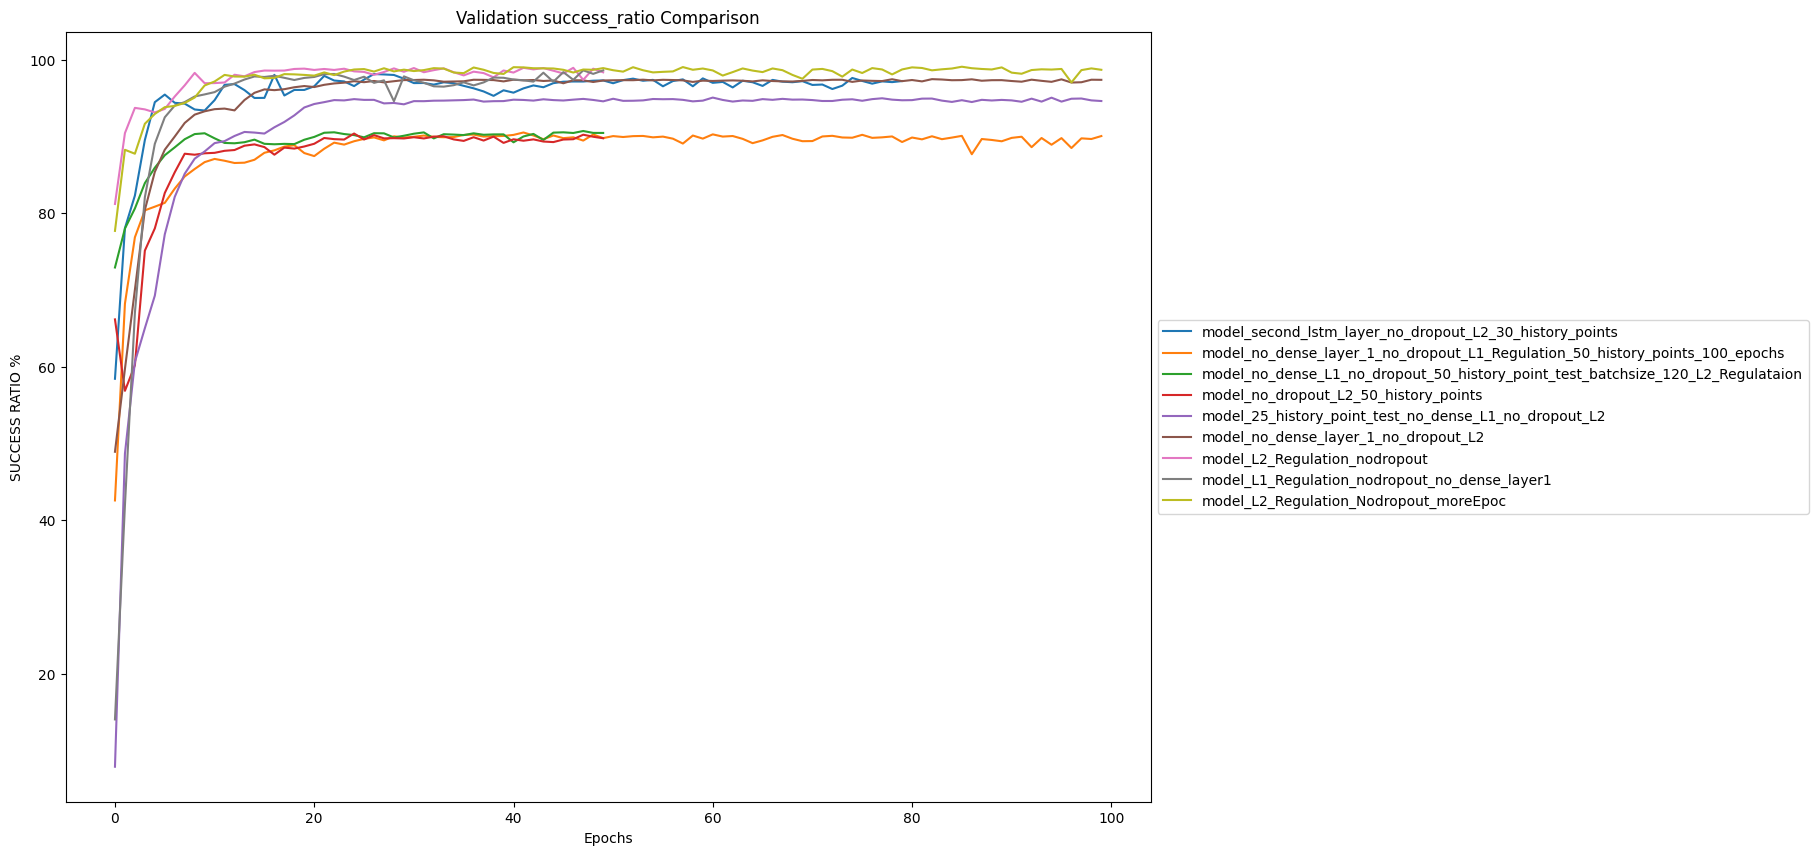

In [68]:
plt.figure(figsize=(14, 10))
for model_name in results:
    plt.plot(results[model_name]['val_success'], label=f'{model_name}')
plt.title('Validation success_ratio Comparison')
plt.xlabel('Epochs')
plt.ylabel('SUCCESS RATIO %')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plotplt.grid(True)
plt.show()

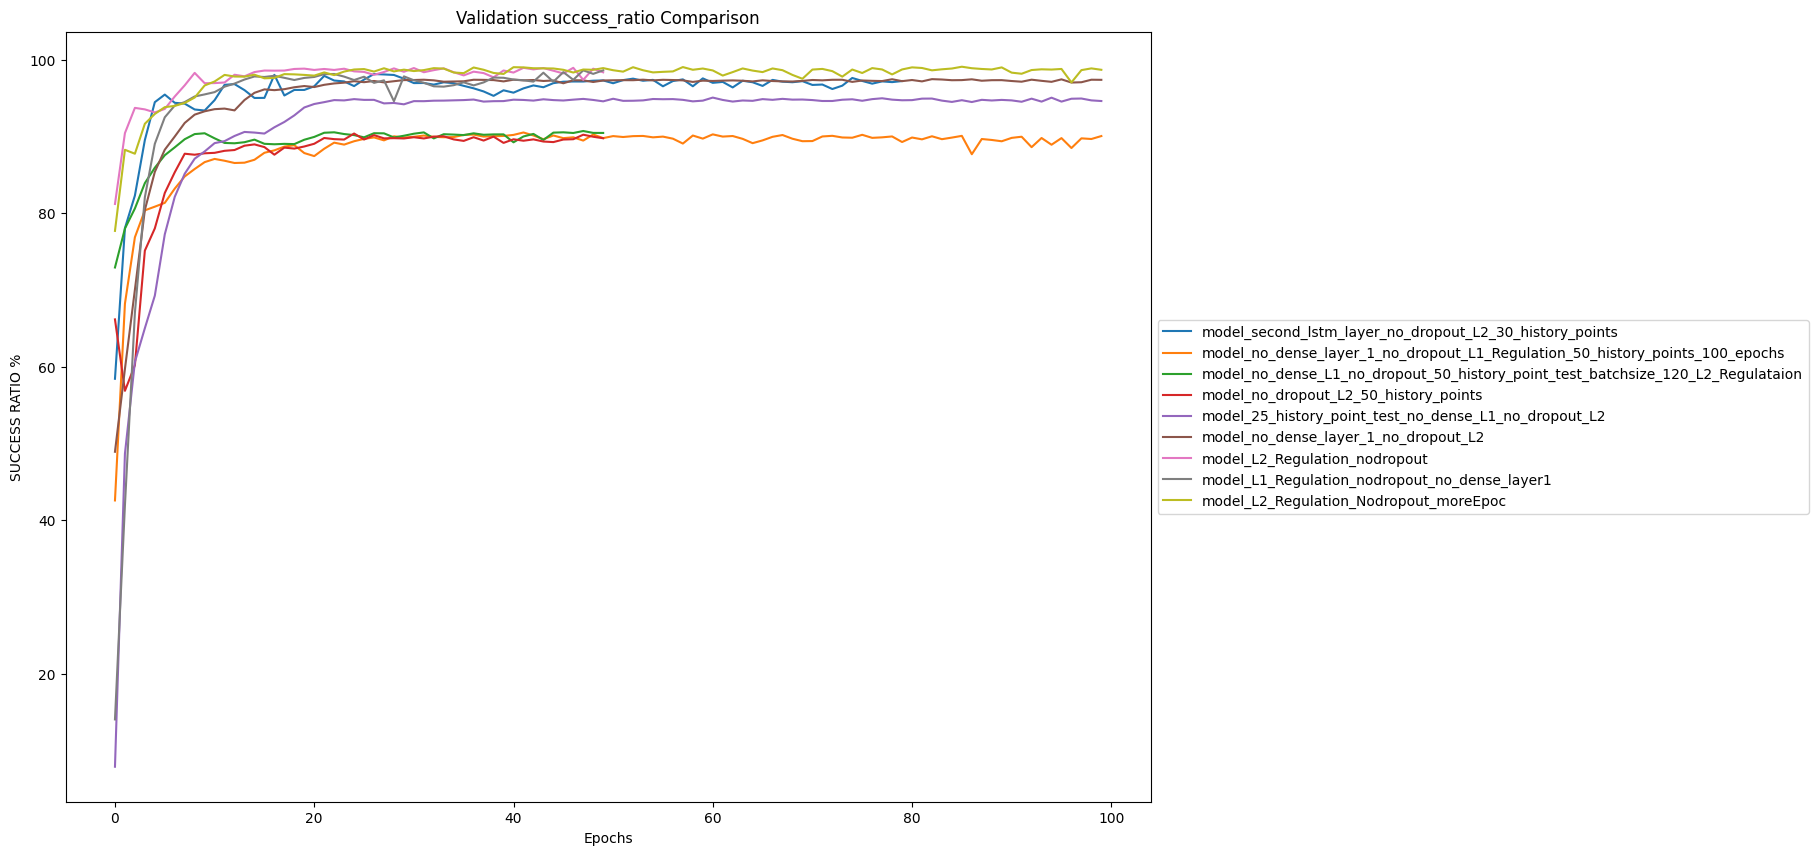

In [69]:
plt.figure(figsize=(14, 10))
for model_name in results:
    plt.plot(results[model_name]['val_success'], label=f'{model_name}')
plt.title('Validation success_ratio Comparison')
plt.xlabel('Epochs')
plt.ylabel('SUCCESS RATIO %')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plotplt.grid(True)
plt.show()

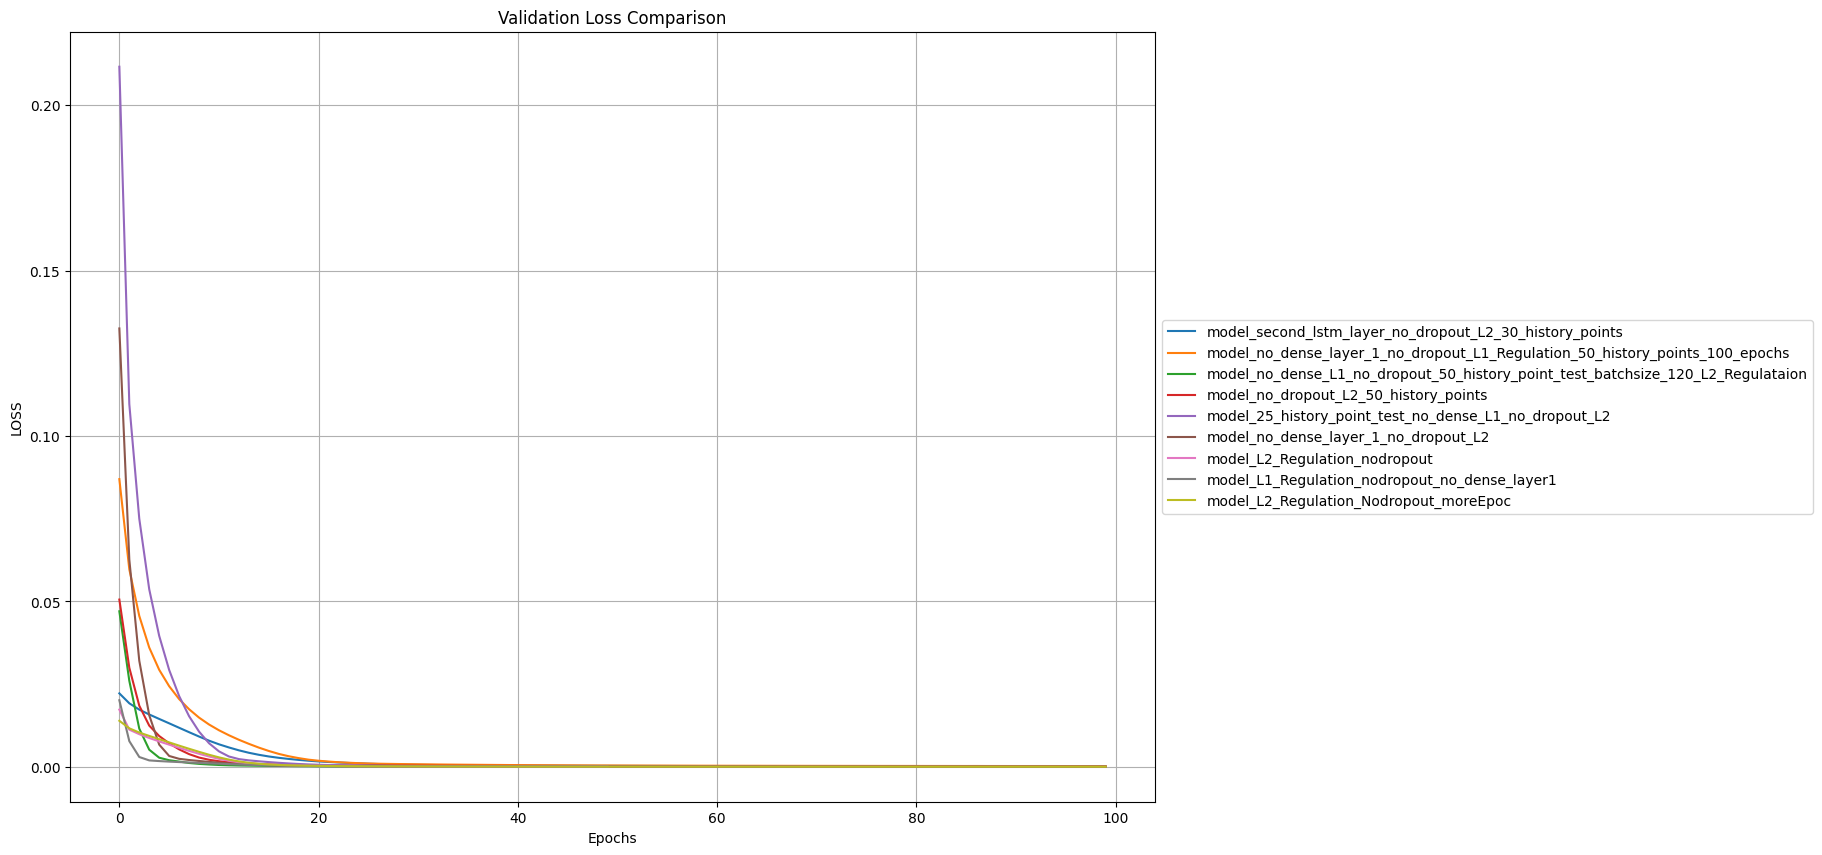

In [70]:
plt.figure(figsize=(14, 10))
for model_name in results:
    plt.plot(results[model_name]['val_loss'], label=f'{model_name}')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot
plt.grid(True)
plt.show()

In [1]:
print("our decision is the pink model: model_L2_Regulation_nodropout")
print("The model fighting with the model_L2_Regulation_Nodropout_moreEpoc , but our model achived less loss with less epoch.")

our decision is the pink model: model_L2_Regulation_nodropout
The model fighting with the model_L2_Regulation_Nodropout_moreEpoc , but our model achived less loss with less epoch.
